# Block by Block Functions - DeepSeek
- vLLM in fp16


### TODO:
1. Use string output in case there is no code output
2. Feed error message into code retries
3. Submit to Kaggle

In [1]:
import os, io
import json
import uuid
from pathlib import Path
from datetime import datetime
import re, sys, subprocess, gc
import time
import multiprocessing
import statsmodels.api as sm

import pandas as pd
import numpy as np
import torch
from vllm import LLM, SamplingParams
from multiprocessing import Pool

n_questions = 10
n_reps_per_prompt = 3
n_code_retries = 4
code_timeout_secs = 2
temperature = 0.9
code_temperature = 0.3
n_code_processes = 8

np.random.seed(42)

def free_mem():
    if hasattr(sys, 'last_traceback'):
        sys.last_traceback.tb_next = None
    gc.collect()
    torch.cuda.empty_cache()

def print_cuda_mem():
    total_memory = torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)
    cached_memory = torch.cuda.memory_reserved(0) / (1024 ** 3)
    available_memory = total_memory - cached_memory 
    print(f"Available Memory (GB, approx.): {available_memory:.2f}")

ds_math_rl = "deepseek-ai/deepseek-math-7b-rl"
#"mixtral · 8x7b-instruct-v0.1-hf" ???


torch_dtype = torch.bfloat16
# to avoid warning when spawing processes to evaluate code later
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
print_cuda_mem()

if not 'vllm' in globals():
    vllm = LLM(model=ds_math_rl,
               dtype='half',
               enforce_eager=True,
               gpu_memory_utilization=0.99,
               swap_space=4,
               max_model_len=2048,
               kv_cache_dtype="fp8_e5m2",
               tensor_parallel_size=1)
vtokenizer = vllm.get_tokenizer()

Available Memory (GB, approx.): 23.64
WARNING 05-06 11:05:38 config.py:767] Casting torch.bfloat16 to torch.float16.
INFO 05-06 11:05:38 config.py:381] Using fp8_e5m2 data type to store kv cache. It reduces the GPU memory footprint and boosts the performance. But it may cause slight accuracy drop. Currently we only support fp8 without scaling factors and make e5m2 as a default format.
INFO 05-06 11:05:38 llm_engine.py:74] Initializing an LLM engine (v0.4.0.post1) with config: model='deepseek-ai/deepseek-math-7b-rl', tokenizer='deepseek-ai/deepseek-math-7b-rl', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=auto, tensor_parallel_size=1, disable_custom_all_reduce=True, quantization=None, enforce_eager=True, kv_cache_dtype=fp8_e5m2, device_config=cuda, seed=0)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 05-06 11:05:39 selector.py:51] Cannot use FlashAttention because the package is not found. Please install it for better performance.
INFO 05-06 11:05:39 selector.py:25] Using XFormers backend.
INFO 05-06 11:05:40 weight_utils.py:177] Using model weights format ['*.safetensors']
INFO 05-06 11:05:43 model_runner.py:104] Loading model weights took 12.8725 GB
INFO 05-06 11:05:43 gpu_executor.py:94] # GPU blocks: 2569, # CPU blocks: 1092


In [2]:
q_df = pd.read_csv('./train.csv')
print(q_df.iloc[0]['problem'])
q_df.iloc[0]['answer']
q_df[:3]

Let $k, l > 0$ be parameters. The parabola $y = kx^2 - 2kx + l$ intersects the line $y = 4$ at two points $A$ and $B$. These points are distance 6 apart. What is the sum of the squares of the distances from $A$ and $B$ to the origin?


,id,problem,answer
0,229ee8,"Let $k, l > 0$ be parameters. The parabola $y ...",52
1,246d26,Each of the three-digits numbers $111$ to $999...,250
2,2fc4ad,Let the `sparkle' operation on positive intege...,702


In [3]:
from MATH.math_equivalence import is_equiv
def extract_answer(text, boxed_in_tool_instruction=True):
    pattern = r"\\boxed\{([^}]*)\}"
    matches = re.findall(pattern, text)
    n_matches = 2 if boxed_in_tool_instruction else 1
    
    if len(matches) >= n_matches:
        try:
            return int(matches[-1]) % 1000
        except ValueError:
            return None

    numbers = re.findall(r'[+-]?\d+', text)
    return int(numbers[-1]) % 1000 if numbers else -1

def extract_correct(text):
    return extract_answer(text, False)

def read_math_data(folder_path, train_test):
    folder = Path(folder_path)
    math_data = []
    for sub_folder in os.listdir(folder):
        if not os.path.isdir(folder/sub_folder):
            continue
        for file_name in os.listdir(folder/sub_folder):
            if file_name.endswith('.json'):
                with open(folder / sub_folder / file_name, 'r') as file:
                    data = json.load(file)
                    data['id'] = train_test + '-' + sub_folder + '-' + file_name[:-5]
                    math_data.append(data)
    return pd.DataFrame(math_data)

math_train = read_math_data('./MATH/train', 'train')
math_train['answer'] = math_train['solution'].map(extract_correct)
math_train = math_train[math_train['answer'].notnull()]
math_train['answer'] = math_train['answer'].astype(int)
math_test = read_math_data('./MATH/test', 'test')
math_test['answer'] = math_test['solution'].map(extract_correct)
math_test = math_test[math_test['answer'].notnull()]
math_test['answer'] = math_test['answer'].astype(int)
print(math_train.shape, math_test.shape)

(4748, 6) (3119, 6)


- 1 yes
- 2 no
- 3 no
- 4 yes
- 5 maybe
- 6 maybe
- 7 yes
- 8 maybe
- 9 yes
- 10 no

In [4]:
math_samp = math_test[math_test['level'].isin(['Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5'])].sample(n_questions)
math_samp.columns

Index(['problem', 'level', 'type', 'solution', 'id', 'answer'], dtype='object')

In [5]:
# with pd.option_context('display.max_rows', None):
display(math_samp[:3])

,problem,level,type,solution,id,answer
2857,Given $2^a = 32$ and $a^b = 125$ find $b^a$.,Level 1,Algebra,We note that $32 = 2 \cdot 2\cdot 2\cdot 2\cdo...,test-algebra-756,243
3540,How many distinct three-letter sequences with ...,Level 5,Counting & Probability,We solve by casework.\n\n$\bullet$ Case I: Exa...,test-counting_and_probability-381,48
3975,Compute $\cos 180^\circ$.,Level 1,Precalculus,"Rotating the point $(1,0)$ about the origin by...",test-precalculus-1282,999


# Batched Inference

In [6]:
short_instruction = "\nPlease reason step by step and use Python code. The final answer is an integer and should be placed within \\boxed{}."
short_code_instruction = "\nDescribe a high level strategy to solve the problem. Output Python with SymPy code to solve the problem. The final answer is an integer and should be placed within \\boxed{}."
derive_instruction_long = "\nFirst translate the problem into equations and try to derive useful other equations.\n" \
                          + "Then use Python code to solve the problem. The final answer is an integer and should be placed within \\boxed{}."
early_win_instruction = """\nTo solve the problem first determine a sympy-based approach for solving the problem by listing each step to take and what functions need to be called in each step.\n
Write a Python script covering all the steps and print the result. The final answer is an integer and should be placed within \\boxed{}.

Approach:"""

prompt_variations = {
    'short_instruction' : short_instruction,
    'short_code_instruction' : short_code_instruction,
    'derive_instruction_long': derive_instruction_long,
    'early_win_instruction': early_win_instruction
}

In [25]:
def is_iterable(var):
    try:
        iter(var)
        return True
    except TypeError:
        return False

def creat_chat_prompt_df(problems):
    if not is_iterable(problems):
        problems = [problems]
    with_chat_prompts = []
    for rep in range(n_reps_per_prompt):
        for inst_idx, short_and_full_inst in enumerate(prompt_variations.items()):
            for i, problem in enumerate(problems):
                instruction = short_and_full_inst[1]
                prompt = problem + instruction
                messages = [{"role": "user", "content": prompt}]
                chat_prompt = vtokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
                with_chat_prompts.append({
                    'problem_id': math_samp.iloc[i]['id'],
                    'problem': math_samp.iloc[i]['problem'],
                    'correct_answer': math_samp.iloc[i]['answer'],
                    'iteration': 0,
                    'rep': rep * len(prompt_variations) + inst_idx,
                    'level': math_samp.iloc[i]['level'],
                    'type': math_samp.iloc[i]['type'],
                    'prompt_variation': short_and_full_inst[0],
                    'raw_prompt': prompt,
                    'chat_prompt': chat_prompt
                })
    return pd.DataFrame(with_chat_prompts)

def gen_before_code(df_prompts):
    tool_sampling_params = SamplingParams(n=1,
                                          temperature=temperature,
                                          max_tokens=1400,
                                          stop='python',
                                          include_stop_str_in_output=True)
    before_code_out = vllm.generate(df_prompts['chat_prompt'], tool_sampling_params)

    n_out_tokens = 0
    out_before_code = []
    n_before_code_tokens = []
    for output in before_code_out:
        out_before_code.append(output.outputs[0].text)
        n_before_code_tokens.append(len(output.outputs[0].token_ids))
    df_res['out_before_code'] = out_before_code
    df_res['n_before_code_tokens'] = n_before_code_tokens


### !!! Most answers before the code already tried to completely answer the question.

### ToDo: Try out a code focussed instruction for code generation

In [20]:
def gen_code(df_res):
    df_res['code_prompt'] = df_res['chat_prompt'] + df_res['out_before_code']
    python_rows = df_res['code_prompt'].str.endswith('python')
    df_res.loc[~python_rows, 'code_prompt'] += "\n```python\n"

    code_sampling_params = SamplingParams(n=1,
                                          temperature=code_temperature,
                                          max_tokens=1900,
                                          stop='```')
    code_out = vllm.generate(df_res['code_prompt'], code_sampling_params)

    code_results = []
    n_code_tokens = []
    for output in code_out:
        code_results.append(output.outputs[0].text)
        n_code_tokens.append(len(output.outputs[0].token_ids))
    df_res['code'] = code_results
    df_res['n_code_tokens'] = n_code_tokens

In [21]:
def parse_code(output):
    if '```python\n' in output:
        try:
            output = output.split(python_code_prefix)[-1]
        except:
            return None   
    if '```' in output:
        output = output.split('```')[0]
    #output = python_default_imports + output
    return add_workarounds(output)

def add_workarounds(code):
    import re
    def repl(match):
        if "real" not in match.group():
            return "{}{}".format(match.group()[:-1], ', real=True)')
        else:
            return "{}{}".format(match.group()[:-1], ')')
    code = re.sub(r"symbols\([^)]+\)", repl, code)
    
    pattern = r"\s(?:cbrt|root)\((.*?)(?:, 3)?\)"
    replacement = r"real_root(\1, 3)"
    code = re.sub(pattern, replacement, code)
    code = re.sub(r'permutations\(', 'itertools.permutations(', code)
    
    code = 'from sympy import *\nimport math, itertools\n' + code
    if 'np.' in code:
        code = 'import numpy as np\n' + code
    return code

def run_with_timeout(code, timeout):
    #ToDo: check whether sometimes there is a print of the corect result before an exception
    
    unique_filename = f'code_{uuid.uuid4().hex}.py'
    with open(unique_filename, 'w') as fout:
        fout.write(code)

    batcmd = f'timeout {timeout} {sys.executable} {unique_filename}'
    try:
        shell_output = subprocess.check_output(batcmd, stderr=subprocess.STDOUT, shell=True).decode('utf8')
    except subprocess.CalledProcessError as e:
        shell_output = e.output.decode('utf8')  # Get the output which may include Python error messages
    try:
        out_eval = eval(shell_output.strip())
        if type(out_eval) == list:
            out_eval = out_eval[0]
        code_output = round(float(out_eval)) % 1000  # <----------   !!!!!!!!!!!!   modulo important for competition
    except Exception as e:
        code_output = shell_output
    os.remove(unique_filename)
    return code_output

def parse_and_run(code):
    try:
        code = parse_code(code)
    except Exception as ex:
        return str(ex)
    try:
        return run_with_timeout(code, code_timeout_secs)
    except Exception as ex:
        return str(ex)
    
def run_code_parallel(code_series):
    with Pool(processes=n_code_processes) as pool:
        return pool.map(parse_and_run, [item for item in code_series])

In [43]:
increasing_code_temperature = code_temperature

def retry_code(df_res):
    global increasing_code_temperature
    for i in range(n_code_retries):
        if increasing_code_temperature <= 0.8:
            increasing_code_temperature += 0.2
        else:
            increasing_code_temperature = 1

        missing = df_res[df_res['int_code_result'] == -1]
        print(f"{len(missing)} missing or non-numerical code results")
        last_error_lines = missing['code_result'].str.split('\n').apply(lambda x: '\n'.join(x[-10:]))
        new_user_prompts = missing['raw_prompt'] + '\nTry to avoid this error from the previous attempt: \n\n' + last_error_lines 
        m_prompts = []
        for prompt in new_user_prompts:
            messages = [{"role": "user", "content": prompt}]
            m_prompt = vtokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
            m_prompts.append(m_prompt)
        missing['code_prompt'] = np.array(m_prompts) + missing['out_before_code']
            
        code_sampling_params = SamplingParams(n=1,
                                          temperature=code_temperature,
                                          max_tokens=1900,
                                          stop='```')
        code_out = vllm.generate(missing['code_prompt'].values, code_sampling_params)

        n_out_tokens = 0
        code_results = []
        n_code_tokens = []
        for output in code_out:
            code_results.append(output.outputs[0].text)
            n_code_tokens.append(len(output.outputs[0].token_ids))
        df_res.loc[missing.index, 'code'] = code_results
        df_res.loc[missing.index, 'n_code_tokens'] = n_code_tokens

        start_time = time.time()
        df_res.loc[missing.index, 'code_result'] = run_code_parallel(df_res.loc[missing.index, 'code'])
        print(f"Ran code outputs in {round(time.time() - start_time)}s")

        df_res.loc[missing.index, 'int_code_result'] = pd.to_numeric(df_res.loc[missing.index ,'code_result'], errors='coerce')
        df_res['int_code_result'] = df_res['int_code_result'].fillna(-1).astype(int)

In [37]:
df_res = creat_chat_prompt_df(math_samp['problem'])
gen_before_code(df_res)

Processed prompts: 100%|██████████| 120/120 [00:29<00:00,  4.14it/s]



 Row 0:
 First, we solve $2^a = 32$. We find that $2^5 = 32$, so $a = 5$.
Then, we solve $a^b = 125$. We substitute $a = 5$ and get $5^b = 125$. We find that $5^3 = 125$, so $b = 3$.
Finally, we need to find $b^a$. We substitute $a = 5$ and $b = 3$ and get $3^5 = 243$.
So $b^a = 243$. The answer is: $243$.

 Row 1:
 First, we find the total number of all three-letter sequences formed by using three of the six letters of $TARGET$. This is simply $6P3 = 6*5*4 = 120$.

Next, we find the number of all three-letter sequences formed by using three of the six letters of $TARGET$ that do not contain the letter $T$. This is simply $4P3 = 4*3*2 = 24$.

The number of distinct three-letter sequences with at least one $``T"$ can be found by subtracting the second result from the first.

```python

 Row 2:
 The value of $\cos 180^\circ$ is $-1$. This can be found using the unit circle or the special right triangles in trigonometry. Therefore, the answer is $\boxed{-1}$.

 Row 3:
 If Beatrice took $

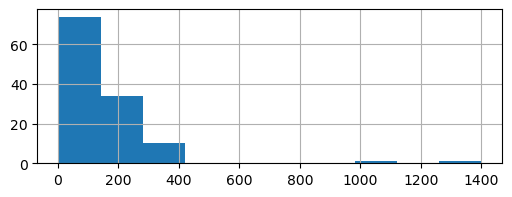

In [38]:
for i in range(5):
    print(f'\n Row {i}:')
    df_res['level'].iloc[i], df_res['problem'].iloc[i], df_res['correct_answer'].iloc[i]
    print(df_res['out_before_code'].iloc[i])
_= df_res['n_before_code_tokens'].hist(figsize=(6,2))

In [39]:
gen_code(df_res)

Processed prompts: 100%|██████████| 120/120 [00:09<00:00, 12.76it/s]


In [40]:
df_res['parsed_code'] = df_res['code'].map(parse_code)
start_time = time.time()
df_res['code_result'] = run_code_parallel(df_res['code'])
print(f"Ran code outputs in {round(time.time() - start_time)}s")
df_res['int_code_result'] = pd.to_numeric(df_res['code_result'], errors='coerce')
df_res['int_code_result'].fillna(-1, inplace=True)

Ran code outputs in 3s


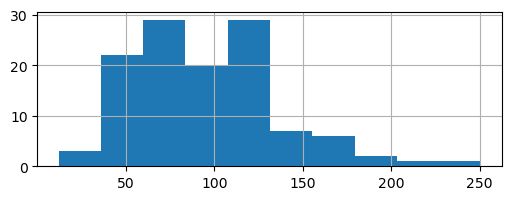

In [41]:
_= df_res['n_code_tokens'].hist(figsize=(6,2))

In [42]:
retry_code(df_res)
missing = df_res[df_res['int_code_result'] == -1]
print(f"{len(missing)} missing or non-numerical code results")

/tmp/ipykernel_5796/59411222.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing['code_prompt'] = np.array(m_prompts) + missing['out_before_code']


10 missing or non-numerical code results
<｜begin▁of▁sentence｜>User: Find the integer that lies between $\sqrt[3]{-45}$ and $\sqrt[3]{-101}$.
Please reason step by step and use Python code. The final answer is an integer and should be placed within \boxed{}.
Try to avoid this error from the previous attempt: 

Traceback (most recent call last):
  File "/home/daniel/code/math-ai/code_144181b911204290a7027520b2683d6e.py", line 15, in <module>
    result = find_integer()
             ^^^^^^^^^^^^^^
  File "/home/daniel/code/math-ai/code_144181b911204290a7027520b2683d6e.py", line 11, in find_integer
    for i in range(lower_bound, upper_bound):
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: 'float' object cannot be interpreted as an integer


Assistant: We can use Python's built-in `cbrt` function to find the cube roots of -45 and -101.

```python


Processed prompts: 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]
/tmp/ipykernel_5796/59411222.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing['code_prompt'] = np.array(m_prompts) + missing['out_before_code']


Ran code outputs in 0s
8 missing or non-numerical code results
<｜begin▁of▁sentence｜>User: Find the integer that lies between $\sqrt[3]{-45}$ and $\sqrt[3]{-101}$.
Please reason step by step and use Python code. The final answer is an integer and should be placed within \boxed{}.
Try to avoid this error from the previous attempt: 

None


Assistant: We can use Python's built-in `cbrt` function to find the cube roots of -45 and -101.

```python


Processed prompts: 100%|██████████| 8/8 [00:02<00:00,  3.51it/s]
/tmp/ipykernel_5796/59411222.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing['code_prompt'] = np.array(m_prompts) + missing['out_before_code']


Ran code outputs in 0s
7 missing or non-numerical code results
<｜begin▁of▁sentence｜>User: Find the integer that lies between $\sqrt[3]{-45}$ and $\sqrt[3]{-101}$.
Please reason step by step and use Python code. The final answer is an integer and should be placed within \boxed{}.
Try to avoid this error from the previous attempt: 

None


Assistant: We can use Python's built-in `cbrt` function to find the cube roots of -45 and -101.

```python


Processed prompts: 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]
/tmp/ipykernel_5796/59411222.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing['code_prompt'] = np.array(m_prompts) + missing['out_before_code']


Ran code outputs in 0s
6 missing or non-numerical code results
<｜begin▁of▁sentence｜>User: Find the integer that lies between $\sqrt[3]{-45}$ and $\sqrt[3]{-101}$.
Please reason step by step and use Python code. The final answer is an integer and should be placed within \boxed{}.
Try to avoid this error from the previous attempt: 

None


Assistant: We can use Python's built-in `cbrt` function to find the cube roots of -45 and -101.

```python


Processed prompts: 100%|██████████| 6/6 [00:01<00:00,  3.13it/s]


Ran code outputs in 0s
6 missing or non-numerical code results


In [ ]:
missing['code_prompt'].str.len().hist(figsize=(6,3))

<Axes: >

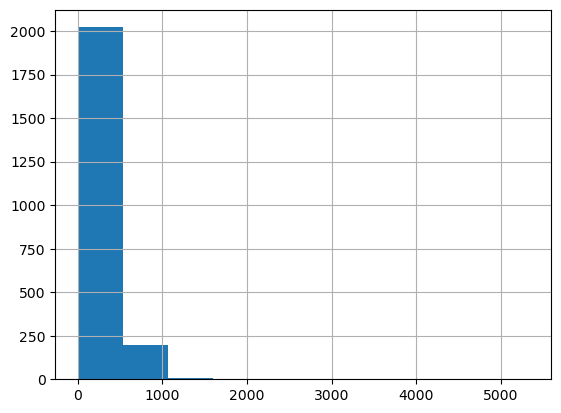

In [24]:
last_error_lines.str.len().hist(figsize=(6,3))

### Inspect code errors

In [25]:
missing['code_prompt'].iloc[0]

'<｜begin▁of▁sentence｜>User: Find the minimum value of $\\frac{9x^2\\sin^2 x + 4}{x\\sin x}$ for $0 < x < \\pi.$\nPlease reason step by step and use Python code. The final answer is an integer and should be placed within \\boxed{}.\nTry to avoid this error from the previous attempt: \n\n    return _derivative_dispatch(self, *symbols, **assumptions)\n           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/home/daniel/mambaforge/envs/pytorch/lib/python3.11/site-packages/sympy/core/function.py", line 1909, in _derivative_dispatch\n    return Derivative(expr, *variables, **kwargs)\n           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/home/daniel/mambaforge/envs/pytorch/lib/python3.11/site-packages/sympy/core/function.py", line 1334, in __new__\n    raise ValueError(filldedent(\'\'\'\nValueError: \nCan\'t calculate derivative wrt x*sin(x).\n\n\nAssistant: We can rewrite the expression as $\\frac{9x^2\\sin^2 x + 4}{x\\sin x} = 9x\\sin x + \\frac{4}{x\\sin x}$.\n\nNow, 

In [26]:
rows = df_res['int_code_result'] == -1

In [34]:
df_res

In [33]:
for i in range(3):
    print(f'\nRow {i}') 
    print(df_res.iloc[i]['problem'])
    print(df_res.iloc[i]['parsed_code'])


Row 0


AttributeError: 'NoneType' object has no attribute 'iloc'

from sympy import *
import math, itertools
from sympy import symbols, diff, solve, sin

def find_minimum():
    x = symbols('x', real=True)
    y = x * sin(x)
    expr = 9 * y + 4 / y
    expr_derivative = diff(expr, y)
    critical_points = solve(expr_derivative, y)
    minimum_value = expr.subs(y, critical_points[0])
    return minimum_value

minimum_value = find_minimum()
print(minimum_value)



In [30]:
print(run_with_timeout(df_res[rows]['parsed_code'].iloc[i], 3))

Traceback (most recent call last):
  File "/home/daniel/code/math-ai/code_f676bbd5ed6c4267a0668811ab57d82e.py", line 14, in <module>
    minimum_value = find_minimum()
                    ^^^^^^^^^^^^^^
  File "/home/daniel/code/math-ai/code_f676bbd5ed6c4267a0668811ab57d82e.py", line 9, in find_minimum
    expr_derivative = diff(expr, y)
                      ^^^^^^^^^^^^^
  File "/home/daniel/mambaforge/envs/pytorch/lib/python3.11/site-packages/sympy/core/function.py", line 2482, in diff
    return f.diff(*symbols, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/daniel/mambaforge/envs/pytorch/lib/python3.11/site-packages/sympy/core/expr.py", line 3586, in diff
    return _derivative_dispatch(self, *symbols, **assumptions)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/daniel/mambaforge/envs/pytorch/lib/python3.11/site-packages/sympy/core/function.py", line 1909, in _derivative_dispatch
    return Derivative(expr, *variables, **kwargs)
      

In [31]:
print(run_with_timeout(df_res[rows]['parsed_code'].iloc[i], 3))

Traceback (most recent call last):
  File "/home/daniel/code/math-ai/code_7ba7511941a84f02b63710fd68f0e302.py", line 14, in <module>
    minimum_value = find_minimum()
                    ^^^^^^^^^^^^^^
  File "/home/daniel/code/math-ai/code_7ba7511941a84f02b63710fd68f0e302.py", line 9, in find_minimum
    expr_derivative = diff(expr, y)
                      ^^^^^^^^^^^^^
  File "/home/daniel/mambaforge/envs/pytorch/lib/python3.11/site-packages/sympy/core/function.py", line 2482, in diff
    return f.diff(*symbols, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/daniel/mambaforge/envs/pytorch/lib/python3.11/site-packages/sympy/core/expr.py", line 3586, in diff
    return _derivative_dispatch(self, *symbols, **assumptions)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/daniel/mambaforge/envs/pytorch/lib/python3.11/site-packages/sympy/core/function.py", line 1909, in _derivative_dispatch
    return Derivative(expr, *variables, **kwargs)
      

In [32]:
df_res['code_result'].astype(str).str.slice(0, 10).values[:100]

array(['243', '96', '999', '10', '80', '2', '4', '996', '40', '50', '23',
       '6', '75', '3', '21', '21', '78', '14', '2', '0', '11', '10', '4',
       '5', '500', '1', '18', '0', '1', '9', '999', '2', '88', '999', '7',
       '2', '5', '1', 'Traceback ', '1', 'Traceback ', '189', '231', '31',
       '16', '672', 'Traceback ', '-2 + 2*pi\n', '4', '24', '4', '6',
       '12', '[]\n', '21', '10', '9', '9', '20', '', '0', '36', '111', '',
       '25', '42', '143', '3', 'Traceback ', '4', '2', '24', '2', '997',
       '8', '[(-18/d2, ', '31', '979', '96*sqrt(13', '80', '16', '372',
       '5', '198', '13', 'Traceback ', '3*sqrt(5) ', '4', '90', '2', '2',
       '12', '0', '3', '280', '668', '230', '5', '992', '56'],
      dtype=object)

## Use output to generate answer

In [33]:
df_res['continue_prompt'] = df_res['code_prompt'] + df_res['code'] +'```\n```output\n' + df_res['code_result'].astype(str).str.slice(0, 10) + '\n```\n'

tool_sampling_params = SamplingParams(n=1,
                                      temperature=temperature,
                                      max_tokens=2048)
llm_out = vllm.generate(df_res['continue_prompt'], tool_sampling_params)

continuations = []
n_continue_tokens = []
for llm_output in llm_out:
    continuations.append(llm_output.outputs[0].text)
    n_continue_tokens.append(len(llm_output.outputs[0].token_ids))
    
df_res['continuations'] = continuations
df_res['n_continue_tokens'] = n_continue_tokens
df_res['combined'] = df_res['continue_prompt'] + df_res['continuations']

Processed prompts:   6%|▌         | 691/12000 [02:15<22:59,  8.20it/s]  

WARNING 04-30 18:54:43 scheduler.py:245] Input prompt (2057 tokens) is too long and exceeds limit of 2048


Processed prompts:   7%|▋         | 825/12000 [02:40<33:05,  5.63it/s]  

WARNING 04-30 18:55:08 scheduler.py:245] Input prompt (2061 tokens) is too long and exceeds limit of 2048


Processed prompts:   8%|▊         | 983/12000 [03:12<32:50,  5.59it/s]  

WARNING 04-30 18:55:40 scheduler.py:245] Input prompt (2061 tokens) is too long and exceeds limit of 2048


Processed prompts:  10%|█         | 1232/12000 [04:15<58:33,  3.06it/s]  

WARNING 04-30 18:56:43 scheduler.py:245] Input prompt (2057 tokens) is too long and exceeds limit of 2048


Processed prompts:  13%|█▎        | 1547/12000 [05:24<2:04:17,  1.40it/s]

WARNING 04-30 18:57:52 scheduler.py:245] Input prompt (2057 tokens) is too long and exceeds limit of 2048


Processed prompts:  15%|█▌        | 1819/12000 [06:23<23:16,  7.29it/s]  

WARNING 04-30 18:58:51 scheduler.py:245] Input prompt (2061 tokens) is too long and exceeds limit of 2048


Processed prompts:  19%|█▉        | 2306/12000 [08:19<27:20,  5.91it/s]  

WARNING 04-30 19:00:47 scheduler.py:245] Input prompt (2057 tokens) is too long and exceeds limit of 2048


Processed prompts:  28%|██▊       | 3361/12000 [12:40<1:28:35,  1.63it/s]

WARNING 04-30 19:05:08 scheduler.py:245] Input prompt (2057 tokens) is too long and exceeds limit of 2048


Processed prompts:  39%|███▉      | 4731/12000 [17:36<29:20,  4.13it/s]  

WARNING 04-30 19:10:04 scheduler.py:245] Input prompt (2057 tokens) is too long and exceeds limit of 2048


Processed prompts:  40%|████      | 4837/12000 [18:03<40:45,  2.93it/s]  

WARNING 04-30 19:10:31 scheduler.py:245] Input prompt (2061 tokens) is too long and exceeds limit of 2048


Processed prompts:  42%|████▏     | 4984/12000 [18:43<45:34,  2.57it/s]  

WARNING 04-30 19:11:11 scheduler.py:245] Input prompt (2061 tokens) is too long and exceeds limit of 2048


Processed prompts:  43%|████▎     | 5118/12000 [19:14<26:57,  4.25it/s]  

WARNING 04-30 19:11:42 scheduler.py:245] Input prompt (2057 tokens) is too long and exceeds limit of 2048


Processed prompts:  50%|████▉     | 5947/12000 [22:30<20:03,  5.03it/s]  

WARNING 04-30 19:14:58 scheduler.py:245] Input prompt (2060 tokens) is too long and exceeds limit of 2048


Processed prompts:  54%|█████▍    | 6523/12000 [24:52<38:58,  2.34it/s]  

WARNING 04-30 19:17:20 scheduler.py:245] Input prompt (2057 tokens) is too long and exceeds limit of 2048


Processed prompts:  57%|█████▋    | 6868/12000 [26:14<20:13,  4.23it/s]  

WARNING 04-30 19:18:43 scheduler.py:245] Input prompt (2061 tokens) is too long and exceeds limit of 2048


Processed prompts:  61%|██████    | 7261/12000 [27:47<12:47,  6.17it/s]  

WARNING 04-30 19:20:15 scheduler.py:245] Input prompt (2057 tokens) is too long and exceeds limit of 2048


Processed prompts:  63%|██████▎   | 7579/12000 [29:10<20:40,  3.57it/s]  

WARNING 04-30 19:21:38 scheduler.py:245] Input prompt (2057 tokens) is too long and exceeds limit of 2048


Processed prompts:  65%|██████▌   | 7834/12000 [30:10<21:23,  3.25it/s]

WARNING 04-30 19:22:38 scheduler.py:245] Input prompt (2058 tokens) is too long and exceeds limit of 2048


Processed prompts:  71%|███████   | 8546/12000 [32:28<19:19,  2.98it/s]

WARNING 04-30 19:24:56 scheduler.py:245] Input prompt (2057 tokens) is too long and exceeds limit of 2048
WARNING 04-30 19:24:56 scheduler.py:245] Input prompt (2057 tokens) is too long and exceeds limit of 2048


Processed prompts:  79%|███████▉  | 9509/12000 [36:00<15:06,  2.75it/s]

WARNING 04-30 19:28:28 scheduler.py:245] Input prompt (2061 tokens) is too long and exceeds limit of 2048


Processed prompts:  82%|████████▏ | 9836/12000 [37:25<18:20,  1.97it/s]

WARNING 04-30 19:29:53 scheduler.py:245] Input prompt (2061 tokens) is too long and exceeds limit of 2048


Processed prompts:  82%|████████▏ | 9852/12000 [37:32<12:16,  2.92it/s]

WARNING 04-30 19:30:00 scheduler.py:245] Input prompt (2061 tokens) is too long and exceeds limit of 2048


Processed prompts:  86%|████████▌ | 10312/12000 [39:26<04:13,  6.67it/s]

WARNING 04-30 19:31:54 scheduler.py:245] Input prompt (2057 tokens) is too long and exceeds limit of 2048


Processed prompts:  87%|████████▋ | 10469/12000 [39:57<04:13,  6.04it/s]

WARNING 04-30 19:32:26 scheduler.py:245] Input prompt (2057 tokens) is too long and exceeds limit of 2048


Processed prompts:  88%|████████▊ | 10512/12000 [40:04<06:23,  3.88it/s]

WARNING 04-30 19:32:32 scheduler.py:245] Input prompt (2061 tokens) is too long and exceeds limit of 2048


Processed prompts:  90%|█████████ | 10828/12000 [41:18<05:50,  3.35it/s]

WARNING 04-30 19:33:46 scheduler.py:245] Input prompt (2061 tokens) is too long and exceeds limit of 2048


Processed prompts:  94%|█████████▍| 11275/12000 [43:02<03:01,  3.99it/s]

WARNING 04-30 19:35:30 scheduler.py:245] Input prompt (2057 tokens) is too long and exceeds limit of 2048


Processed prompts: 100%|██████████| 12000/12000 [46:02<00:00,  4.34it/s]


In [34]:
# file_name = 'block_by_block_results_april_29.csv'
# df_res.to_csv(file_name, index=False)
# df_res = pd.read_csv(file_name)
# df_res['problem_id'] = df_res['problem_id'].astype(str)

In [35]:
def standardize_number(number):
    try:
        return int(number)
    except:pass
    try:
        return float(number)
    except: pass
    return -1

In [36]:
df_res['llm_result'] = df_res['combined'].map(extract_answer)
df_res['combined_result'] = df_res['code_result'].fillna(df_res['llm_result'])

## Count Correct

In [37]:
def first_mode(series):
    return series.mode().iloc[0] if not series.mode().empty else None

most_common = df_res.groupby('problem_id')['llm_result'].agg(first_mode)
most_common = most_common.apply(lambda x: x[0] if isinstance(x, np.ndarray) and len(x) >= 1 else x)
most_common = pd.DataFrame(most_common).reset_index()
pooled = math_samp.merge(most_common, left_on='id', right_on='problem_id')
is_correct = []
for row in pooled.iterrows():
    correct = standardize_number(row[1]['llm_result'])
    result = standardize_number(row[1]['answer'])
    is_correct.append(is_equiv(correct, result))
pooled['is_correct'] = is_correct

In [38]:
def logistic_mean_and_cis(binary_series):
    ci_lower, ci_upper = sm.stats.proportion_confint(count=binary_series.sum(), nobs=len(binary_series), alpha=0.05, method='agresti_coull')
    return f"{round(binary_series.mean(),2)} with CI  {round(ci_lower,2)}-{round(ci_upper,2)}"
    
logistic_mean_and_cis(pooled['is_correct'])

'0.7 with CI  0.67-0.72'

In [39]:
pooled.groupby('level')['is_correct'].agg(logistic_mean_and_cis)

level
Level 1    0.94 with CI  0.88-0.97
Level 2    0.84 with CI  0.78-0.89
Level 3    0.78 with CI  0.72-0.83
Level 4     0.66 with CI  0.6-0.72
Level 5    0.41 with CI  0.35-0.48
Name: is_correct, dtype: object

In [40]:
most_common = df_res.groupby(['problem_id', 'prompt_variation'])['llm_result'].agg(first_mode)
most_common = most_common.apply(lambda x: x[0] if isinstance(x, np.ndarray) and len(x) >= 1 else x)
most_common = pd.DataFrame(most_common).reset_index()
most_common

,problem_id,prompt_variation,llm_result
0,test-algebra-1014,derive_instruction_long,7.0
1,test-algebra-1014,early_win_instruction,7.0
2,test-algebra-1014,short_code_instruction,7.0
3,test-algebra-1014,short_instruction,7.0
4,test-algebra-1022,derive_instruction_long,0.0
...,...,...,...
3995,test-precalculus-984,short_instruction,6.0
3996,test-precalculus-991,derive_instruction_long,988.0
3997,test-precalculus-991,early_win_instruction,988.0
3998,test-precalculus-991,short_code_instruction,988.0


In [41]:
prompt_grouped = math_samp.merge(most_common, left_on='id', right_on='problem_id')
is_correct = []
for row in prompt_grouped.iterrows():
    correct = standardize_number(row[1]['llm_result'])
    result = standardize_number(row[1]['answer'])
    is_correct.append(is_equiv(correct, result))
prompt_grouped['is_correct'] = is_correct

In [42]:
import seaborn as sns

<Axes: xlabel='prompt_variation', ylabel='is_correct'>

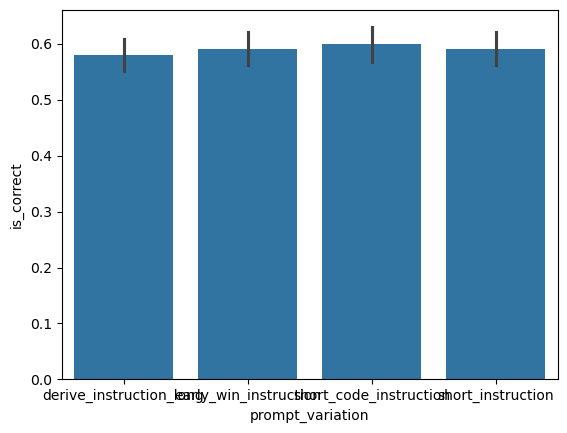

In [43]:
sns.barplot(prompt_grouped, x='prompt_variation', y='is_correct')

In [44]:
print(prompt_grouped['is_correct'].mean())
prompt_grouped.groupby('prompt_variation')['is_correct'].agg(['size', 'mean'])

0.59


,size,mean
prompt_variation,,
derive_instruction_long,1000,0.580
early_win_instruction,1000,0.591
short_code_instruction,1000,0.599
short_instruction,1000,0.590


In [45]:
prompt_grouped.groupby('prompt_variation')['is_correct'].agg(['size', 'mean'])

,size,mean
prompt_variation,,
derive_instruction_long,1000,0.580
early_win_instruction,1000,0.591
short_code_instruction,1000,0.599
short_instruction,1000,0.590


```
0.692
size	mean
level		
Level 1	23	0.826087
Level 2	49	0.816327
Level 3	66	0.787879
Level 4	68	0.647059
Level 5	44	0.409091
```

In [46]:
df_res.to_csv('inject_code_results_april_23_2000.csv', index=False)

In [47]:
pooled.columns

Index(['problem', 'level', 'type', 'solution', 'id', 'answer', 'problem_id',
       'llm_result', 'is_correct'],
      dtype='object')

In [48]:
with pd.option_context('display.max_rows', None):
    display(pooled.loc[(pooled['level'] == 'Level 1') & (~pooled['is_correct']), ['id', 'level', 'type', 'answer', 'llm_result', 'is_correct']])

,id,level,type,answer,llm_result,is_correct
15,test-counting_and_probability-1016,Level 1,Counting & Probability,17,21.0,False
359,test-geometry-808,Level 1,Geometry,90,76.0,False
369,test-precalculus-508,Level 1,Precalculus,941,41.0,False
384,test-number_theory-606,Level 1,Number Theory,5,6.0,False
513,test-geometry-421,Level 1,Geometry,55,40.0,False
573,test-intermediate_algebra-114,Level 1,Intermediate Algebra,512,60.0,False
581,test-counting_and_probability-778,Level 1,Counting & Probability,6,4.0,False


## Inspection of Errors
- Problem 1016: Incorrect minimization of A \cup B via overlaying A and B.

In [ ]:
df_res[df_res['problem_id'] == '808']